In [1]:
from client.model import compile_model, save_parameters
from client.data import load_data
from scaleout.client.edge_client import EdgeClient
import torch
import matplotlib.pyplot as plt
import numpy as np
import client
import client.startup
import importlib

importlib.reload(client.startup)
importlib.reload(client)


model = compile_model()
print(model)

N_clients = 2
edge = EdgeClient()
clients = [client.startup.MyClient(edge) for _ in range(N_clients)]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

Dataset Imagenette
    Number of datapoints: 9469
    Root location: ./max_data
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[236]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
torch.Size([3, 224, 224])
klar inläsning


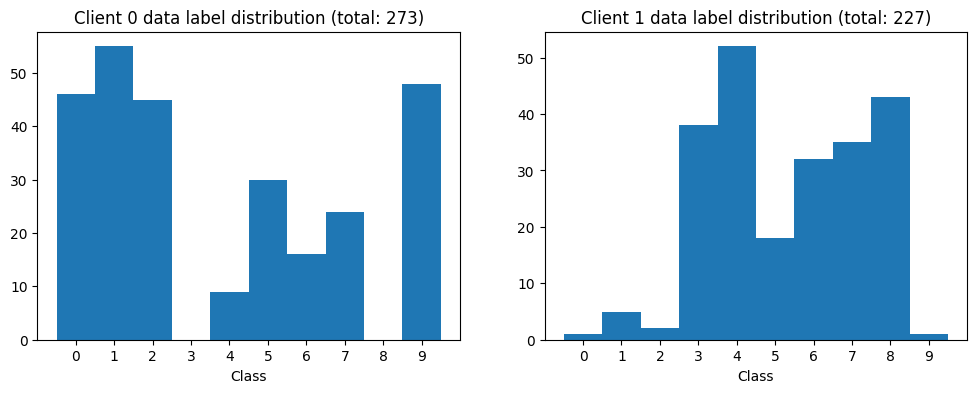

In [2]:
import pickle
import torchvision
from torchvision import transforms, datasets
def niid_loader(data_path=None, dataset_name='mnist', is_train=True, download=False):
    """Implements non-iid data across clients using NIID-bench: 
    https://github.com/Xtra-Computing/NIID-Bench#"""

    
    if data_path == None:
        print('No data path given!')
        return
        
    
    #Imagenette för convnext
    if dataset_name == 'imagenette':
        data = load_data(data_path=data_path, is_train=is_train, download=download)
        print(data)
        print(data[0][0].shape)

        #non-iid map
        with open('./max_dataidx_maps/imagenette_500samples_dataidx_map_labeldir_beta05.pkl', 'rb') as f:
            idx_dict = pickle.load(f)


        with open('./max_dataidx_maps/imagenette_indices.pkl', 'rb') as f:
            indices_map = pickle.load(f)    #Mappar subset-idx till riktiga idx i datasetet


        client_ds = [
            torch.utils.data.Subset(data, indices_map[indices])
            for key, indices in idx_dict.items()
            ]
        
            
    #MNIST
    elif dataset_name == 'mnist':
        data = datasets.MNIST(
            root=data_path, 
            train=is_train,
            download=download,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )

        #non-iid map
        with open('./max_dataidx_maps/net_dataidx_map_labeldir_beta05.pkl', 'rb') as f:
            idx_dict = pickle.load(f)

        client_ds = [
            torch.utils.data.Subset(data, indices)
            for key, indices in idx_dict.items()
            ]
   

    return client_ds

# #IID
# data = datasets.MNIST(
#             root='./max_data', 
#             train=True,
#             download=False,
#             transform=transforms.Compose([
#                 transforms.ToTensor()
#             ])
#         )
# client_ds = torch.utils.data.random_split(data, [0.5, 0.5])


client_ds = niid_loader(
    data_path='./max_data', 
    is_train=True, 
    dataset_name='imagenette',
    )


print('klar inläsning')
labels = [[] for _ in range(N_clients)]
for c in range(N_clients):
    for _, label in client_ds[c]:
        labels[c].append(label)

#Client data distribution
fig, axs = plt.subplots(1,N_clients, figsize=(12,4))
for i, client_labels in enumerate(labels):
    axs[i].hist(client_labels, bins=np.arange(11)-0.5)
    axs[i].set_title(f'Client {i} data label distribution (total: {len(client_labels)})')
    axs[i].set_xlabel('Class')
    axs[i].set_xticks(np.arange(10))
plt.show()

In [3]:
from torch.utils.data import DataLoader, TensorDataset

def dataset_to_tensor(dataset, batch_size=256, num_workers=0):
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

    xs = []
    ys = []

    for x, y in loader:
        xs.append(x)
        ys.append(y)

    X = torch.cat(xs)
    Y = torch.cat(ys)

    return TensorDataset(X, Y)


In [ ]:
from copy import deepcopy
from scaleoututil.serverfunctions.serverfunctionsbase import RoundType
from scaleoututil.utils.model import ScaleoutModel
from collections import defaultdict
import server_functions
importlib.reload(server_functions)


#initialize global params
global_params = save_parameters(model)

client_ids = [i for i in range(N_clients)]
serverfunction = server_functions.ServerFunctions()

ram_datasets = [dataset_to_tensor(ds, batch_size=128) for ds in client_ds]
#print(ram_datasets)
#Dataloaders
client_dl = [torch.utils.data.DataLoader(
    dataset=ds,
    batch_size=32,
    ) 
    for ds in ram_datasets
    ]

metrics_list = defaultdict(lambda: defaultdict(list))


#for .. (this is one FL round)
for round in range(10):
    selected = serverfunction.client_selection(client_ids, RoundType.TRAINING) 
    settings = serverfunction.client_settings(global_params) #Transform to list

    params_list = dict()
    for id in selected:
        #Olika datapartitioner på olika clients
        params, metadata, metrics = clients[id].train(
            scaleout_model=global_params, 
            settings=settings,
            data_loader = client_dl[id]
            )
        params_list[id] =(params.get_model_params(), metadata)
        
        for key, value in metrics.items():
            metrics_list[id][key].append(value)


    #Aggregate
    new_params = serverfunction.adaptive_aggregate(global_params.get_model_params(), params_list, None, 'cosine-sim')
    global_params = global_params.from_model_params(new_params)



Epoch 0/0 | Batch 0/68 | Loss: 2.3168


KeyboardInterrupt: 

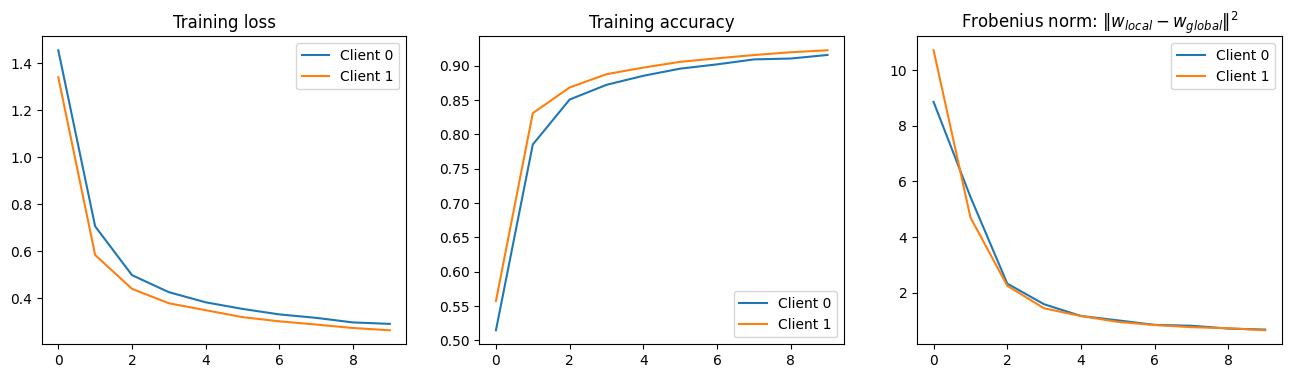

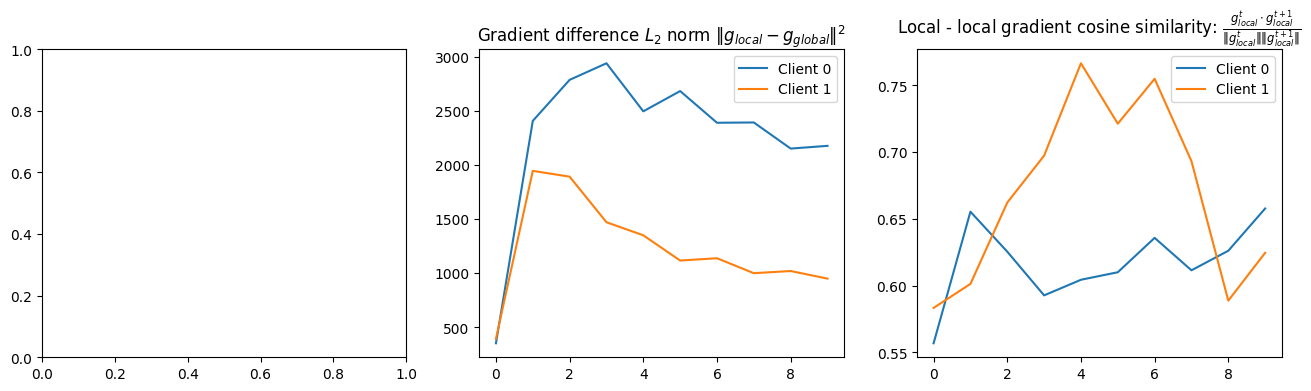

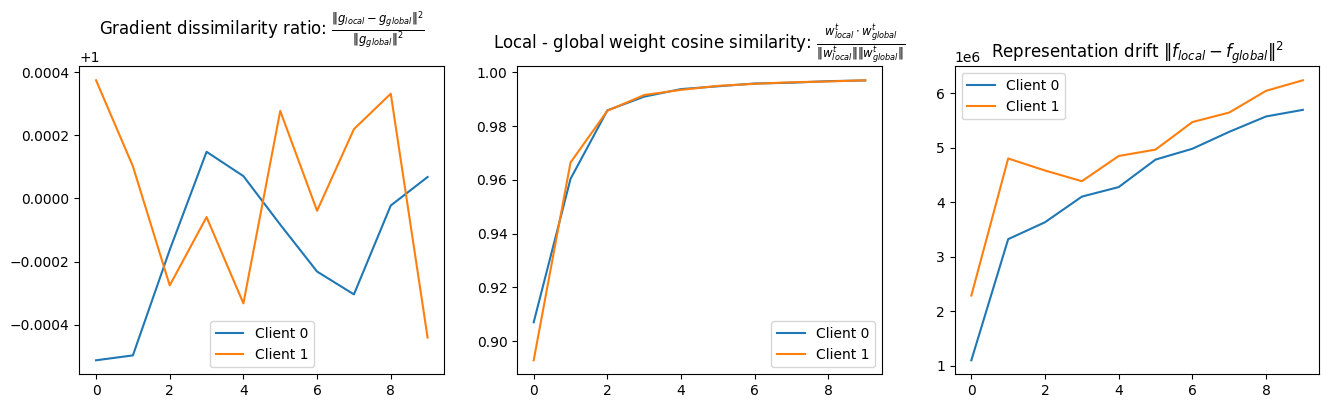

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize=(16,4))
fix, (ax7, ax8, ax9) = plt.subplots(1,3, figsize=(16,4))

def fisher_trace(fisher_dict):
    total = 0.0
    for v in fisher_dict.values():
        total += v.sum().item()
    return total

import torch.nn.functional as F


for id in client_ids:
    ax1.plot(metrics_list[id]['training_loss'], label=f'Client {id}')
    ax2.plot(metrics_list[id]['training_accuracy'], label=f'Client {id}')
    ax3.plot(metrics_list[id]['norm'], label=f'Client {id}')

    #trace = [fisher_trace(d) for d in metrics_list[id]['fisher']]
    #ax4.plot(trace, label=f'Client {id}')


    g_global = torch.stack(metrics_list[id]['global_grad'], dim=1)
    g_local = torch.stack(metrics_list[id]['local_grad'], dim=1)

    norm = torch.linalg.vector_norm(g_local - g_global, dim=0)
    ax5.plot(norm, label=f'Client {id}')


    cos_sim = F.cosine_similarity(g_local[:-1], g_local[1:], dim=0)
    ax6.plot(cos_sim, label=f'Client {id}')

    dissim = torch.norm(g_local - g_global, dim=0)**2 / (
    torch.norm(g_global, dim=0)**2 + 1e-12)
    ax7.plot(dissim, label=f'Client {id}')

    ax8.plot(metrics_list[id]['weight_cosine_sim'], label=f'Client {id}')

    ax9.plot(metrics_list[id]['feature_drift'], label=f'Client {id}')





ax1.legend()
ax1.set_title('Training loss')

ax2.legend()
ax2.set_title('Training accuracy')

ax3.legend()
ax3.set_title(r'Frobenius norm: $\|w_{local} - w_{global}\|^2$')

#ax4.legend()
#ax4.set_title('Fisher information trace')

ax5.legend()
ax5.set_title(r'Gradient difference $L_2$ norm $\| g_{local} - g_{global}\|^2$')

ax6.legend()
ax6.set_title(r'Local - local gradient cosine similarity: $\frac{g_{local}^t \cdot g_{local}^{t+1}}{\|g_{local}^t\|\|g_{local}^{t+1}\|}$')

ax7.legend()
ax7.set_title(r'Gradient dissimilarity ratio: $\frac{\| g_{local} - g_{global} \|^2}{\|g_{global}\|^2} $')

ax8.legend()
ax8.set_title(r'Local - global weight cosine similarity: $\frac{w_{local}^t \cdot w_{global}^t}{\|w_{local}^t\|\|w_{global}^t\|}$')

ax9.legend()
ax9.set_title(r'Representation drift $\|f_{local} - f_{global}\|^2$')
plt.show()


Clients keep training

In [ ]:
from copy import deepcopy
from scaleoututil.serverfunctions.serverfunctionsbase import RoundType
from scaleoututil.utils.model import ScaleoutModel
from collections import defaultdict


clients = [client.startup.MyClient(edge) for _ in range(N_clients)]
#initialize global params
global_params = save_parameters(model)

client_ids = [i for i in range(N_clients)]
server_functions = ServerFunctions()

ram_datasets = [dataset_to_tensor(ds, batch_size=32) for ds in client_ds]
#Dataloaders
client_dl = [torch.utils.data.DataLoader(
    dataset=ds,
    batch_size=32,
    ) 
    for ds in ram_datasets
    ]

metrics_list = defaultdict(lambda: defaultdict(list))

own_params = dict({id: global_params for id in client_ids})
#for .. (this is one FL round)
for round in range(10):
    selected = server_functions.client_selection(client_ids, RoundType.TRAINING, clients, 0.98) 
    settings = server_functions.client_settings(global_params) #Transform to list

    params_list = dict()
    losses = []
    for id in client_ids:
        #Olika datapartitioner på olika clients
        params, metadata, metrics = clients[id].train(
            scaleout_model=own_params[id], #global_params, 
            settings=settings,
            data_loader = client_dl[id]
            )
        if id in selected:
            params_list[id] =(params.get_model_params(), metadata)
        else:
            own_params[id] = params
        
        for key, value in metrics.items():
            metrics_list[id][key].append(value)

        # metrics_list[id]['training_loss'].append(metrics['training_loss'])
        # metrics_list[id]['training_accuracy'].append(metrics['training_accuracy'])
        # metrics_list[id]['norm'].append(metrics['norm'])
    
    #Aggregate
    if len(selected) > 0:
        new_params = server_functions.aggregate(global_params.get_model_params(), params_list)
        global_params = global_params.from_model_params(new_params)
        for id in selected:
            own_params[id] = global_params